# Sentiment Analysis Using Stanford Data

This exploration involves a large dataset of movie reviews from IMDb that has been collected by Maas et al. and used in the paper "Learning Word Vectors for Sentiment Analysis". The dataset can be downloaded from http://ai.stanford.edu/~amaas/data/sentiment/ as a zip archive.


## Importing Libraries and Processing/Loading Data

In [15]:
# Importing necessary libraries
import pyprind # For seeing the progress of loading the data
import pandas as pd
import os
import numpy as np

In [2]:
# Converting the dataset into a dataframe object
'''
The code below will create a dataframe with a column for the text of the review and a column for the sentiment,
with 1 representing a positive sentiment and 0 representing a negative sentiment
'''

pbar = pyprind.ProgBar(50000)
labels = {'pos':1, 'neg':0}
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = './aclImdb/%s/%s' % (s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update() # This allows us to see the action in progress!
df.columns = ['review', 'sentiment'] 

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:00


In [3]:
import numpy as np
np.random.seed(0) # Sets random seed for reproducible results
df = df.reindex(np.random.permutation(df.index)) # Shuffles the data
df.to_csv('./stanford_movie_data.csv', index=False) # for storing the data later

In [2]:
df = pd.read_csv('./stanford_movie_data.csv') #Just to confirm that the data was loaded properly
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


## Cleaning Up The Text Data

In some cases, text data can contain unwanted characters such as HTML markup or punctuation. Since this is the case, we can clean up the text data using Python's regex library.

In [3]:
import re # regex library
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # Effectively removes HTML markup tags
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    return text

In [4]:
# Next we can apply this function to each review
df['review'] = df['review'].apply(preprocessor)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null int64
dtypes: int64(1), object(1)
memory usage: 781.3+ KB


## Using the TF-IDF statistic and training models

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer # Used for vectorizing each review

In [10]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, ngram_range=(1,2))

def tokenizer(text):    # Function for tokenizing text, this is not used here, but defined just in case
    return text.split()

tfidf_log_model = Pipeline([('vectorizer', tfidf), ('log_model', LogisticRegression(penalty='l2', C=10.0))])

In [11]:
# Split into training and testing sets
X_train = df.loc[:30000, 'review'].values
y_train = df.loc[:30000, 'sentiment'].values
X_test = df.loc[30000:, 'review'].values
y_test = df.loc[30000:, 'sentiment'].values

X = df['review'].values
y = df['sentiment'].values

In [12]:
tfidf_log_model.fit(X_train, y_train)

//anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=T...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [13]:
pred = tfidf_log_model.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy of logistic regression model: {}%".format(100*accuracy_score(y_test, pred)))

//anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Accuracy of logistic regression model: 90.86%


### Trying to find optimal regularization strength C

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split

averages = [] 
test_values = list(np.linspace(1, 10, 10)) # A range of 10 values to test
pbar = pyprind.ProgBar(30) # For keeping track of the progress
for val in test_values:
    tfidf_lr = Pipeline([('vectorizer', tfidf), ('log_model', LogisticRegression(penalty='l2', C=val))])
    sum_accuracies = 0 # used to calculate average
    for i in range(3): # This is basically 3-fold CV
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100+i)
        tfidf_lr.fit(X_train, y_train)
        predictions = tfidf_lr.predict(X_test)
        sum_accuracies += 100*accuracy_score(y_test, predictions)
        pbar.update()
    averages.append(sum_accuracies/3.0)
        

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:23:17


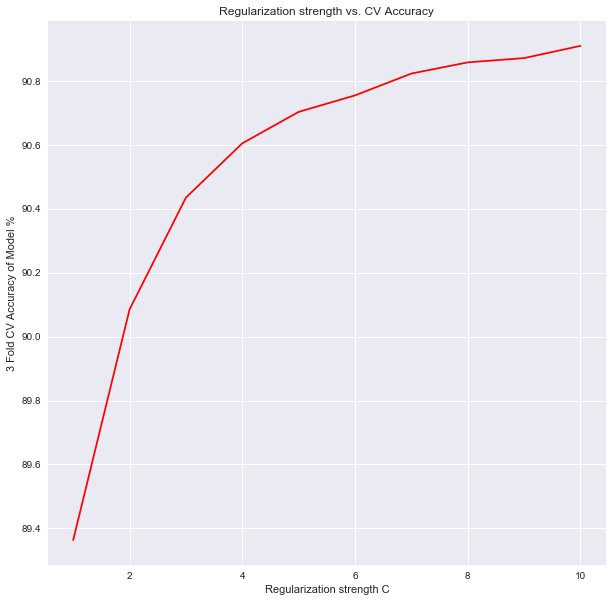

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(np.array(test_values), np.array(averages), color='Red')
plt.xlabel("Regularization strength C")
#plt.ylim(80, 100)
plt.ylabel("3 Fold CV Accuracy of Model %")
plt.title("Regularization strength vs. CV Accuracy")
# Optimal value of C is about 6.158 (chosen from test values)

In [54]:
X_train = df.loc[:30000, 'review'].values
y_train = df.loc[:30000, 'sentiment'].values
X_test = df.loc[30000:, 'review'].values
y_test = df.loc[30000:, 'sentiment'].values

tfidf_log_model = Pipeline([('vectorizer', tfidf), ('log_model', LogisticRegression(penalty='l2', C=22))])
tfidf_log_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=T...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [55]:
pred = tfidf_log_model.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy of logistic regression model: {}%".format(100*accuracy_score(y_test, pred)))

Accuracy of logistic regression model: 90.955%


In [56]:
np.linspace(18,24,7)

array([18., 19., 20., 21., 22., 23., 24.])

In [39]:
# Some more fine-tuning of C parameter
averages2 = [] 
test_values2 = list(np.linspace(12,16,5)) # A range of 5 values to test
pbar = pyprind.ProgBar(15) # For keeping track of the progress
for val in test_values2:
    tfidf_lr = Pipeline([('vectorizer', tfidf), ('log_model', LogisticRegression(penalty='l2', C=val))])
    sum_accuracies = 0 # used to calculate average
    for i in range(3): # This is basically 3-fold CV
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100+i)
        tfidf_lr.fit(X_train, y_train)
        predictions = tfidf_lr.predict(X_test)
        sum_accuracies += 100*accuracy_score(y_test, predictions)
        pbar.update()
    averages2.append(sum_accuracies/3.0)

0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:11:56


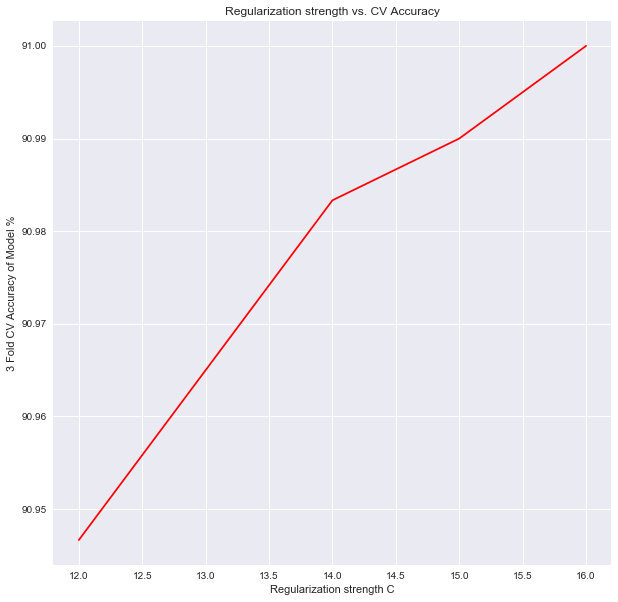

In [40]:
plt.figure(figsize=(10,10))
plt.plot(np.array(test_values2), np.array(averages2), color='Red')
plt.xlabel("Regularization strength C")
#plt.ylim(80, 100)
plt.ylabel("3 Fold CV Accuracy of Model %")
plt.title("Regularization strength vs. CV Accuracy") # The optimal value of C is 4.5 based on the plot

### Best Logistic Regression Model C = 17

In [11]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

tfidf_log_model = Pipeline([('vectorizer', tfidf), ('log_model', LogisticRegression(penalty='l2', C= 4.5))])
tfidf_log_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=T...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [12]:
pred = tfidf_log_model.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy of logistic regression model: {}%".format(100*accuracy_score(y_test, pred)))

Accuracy of logistic regression model: 89.768%


In [13]:
from sklearn.model_selection import cross_val_score
cv_results = cross_val_score(tfidf_log_model, X, y, scoring='accuracy', cv=8)
cv_results

array([ 0.9024 ,  0.90768,  0.90288,  0.90752,  0.90336,  0.90336,
        0.90592,  0.89824])

### Neural networks and Logistic Regression with L1 Regularization

In [11]:
tfidf_neural_net = Pipeline([('vectorizer', tfidf), ('mlp', MLPClassifier(hidden_layer_sizes=(30, 30, 30)))])

In [12]:
import time
start = time.time()
tfidf_neural_net.fit(X_train, y_train)
end = time.time()
print("Time taken to train model: {} s".format(end - start)) # Prints the time taken to train the model

Time taken to train model: 186.71066093444824 s


In [13]:
pred2 = tfidf_neural_net.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy of neural network model: {}%".format(100*accuracy_score(y_test, pred2)))

Accuracy of neural network model: 88.615%


In [14]:
tfidf_log_model_l1 =  Pipeline([('vectorizer', tfidf), ('log_model', LogisticRegression(penalty='l1', C=10.0))])

In [15]:
tfidf_log_model_l1.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=T...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [16]:
pred3 = tfidf_log_model_l1.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy of logistic regression model l1 regularization: {}%".format(100*accuracy_score(y_test, pred3)))

Accuracy of logistic regression model l1 regularization: 88.145%


### Experimenting with Gensim and Word2Vec

In [14]:
from gensim.models.word2vec import Word2Vec

class Word2VecProvider(object):  # Easy to use interface to Word2Vec from gensim library
    word2vec = None
    dimensions = 0

    def load(self, path_to_word2vec):
        self.word2vec = gensim.models.Word2Vec.load_word2vec_format(path_to_word2vec, binary=False)
        self.word2vec.init_sims(replace=True)
        self.dimensions = self.word2vec.vector_size

    def get_vector(self, word):
        if word not in self.word2vec.vocab:
            return None

        return self.word2vec.syn0norm[self.word2vec.vocab[word].index]

    def get_similarity(self, word1, word2):
        if word1 not in self.word2vec.vocab or word2 not in self.word2vec.vocab:
            return None

        return self.word2vec.similarity(word1, word2)

### Majority Voting Classifiers

In [61]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
    
    
        return self
    
    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
        
    def predict_proba(self, X):
        
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s_%s' % (name, key)] = value
        return out

In [62]:
log_models = []
for i in range(3):
    log_models.append(Pipeline([('vectorizer', tfidf), ('log_model', LogisticRegression(penalty='l2', C=4.25+0.25*i))]))
maj_vote_lr = MajorityVoteClassifier(log_models, vote='probability')

In [63]:
cv_results = cross_val_score(maj_vote_lr, X, y, scoring='accuracy', cv=8)
print("Average accuracy of majority voting model: {} %".format(100*sum(cv_results)/len(cv_results)))

Average accuracy of majority voting model: 90.39200000000001 %


In [64]:
maj_vote_lr.fit(X_train, y_train)  # Retrieves misclassifed samples
misclassified = np.where(y_test != maj_vote_lr.predict(X_test))

In [67]:
df.iloc[misclassified] 

,review,sentiment
11,hidden frontier is notable for being the longe...,1
20,opulent sets and sumptuous costumes well photo...,0
26,first of all i d like to tell you that i m int...,0
30,i first saw this movie on a local station on t...,1
74,this movie has lot of downsides and thats all ...,0
102,my left foot is an epic outstanding film expla...,1
110,i tried to sit through this bomb not too long ...,0
139,pretty pretty actresses and actors pretty bad ...,0
151,as everyone knows nobody can play scarlett o h...,0
153,the summary line above spoken by james cloud r...,1


In [69]:
from sklearn.metrics import classification_report
print(classification_report(maj_vote_lr.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.89      0.90      0.90     12443
          1       0.90      0.89      0.90     12557

avg / total       0.90      0.90      0.90     25000



In [18]:
maj_vote_clf = MajorityVoteClassifier([tfidf_log_model, tfidf_log_model_l1, tfidf_neural_net], vote='probability')

In [19]:
maj_vote_clf.fit(X_train, y_train)

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preproces...rue, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])],
            vote='classlabel', weights=None)

In [20]:
pred4 = maj_vote_clf.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy of majority vote classifier: {}%".format(100*accuracy_score(y_test, pred4)))

Accuracy of majority vote classifier: 89.31%


## Trying other Models and Majority Voting

In [32]:
from sklearn.ensemble import RandomForestClassifier
rfc_tfidf = Pipeline([('vectorizer', tfidf), ('rfc', RandomForestClassifier(n_estimators=200))])

In [33]:
import time
start = time.time()
rfc_tfidf.fit(X_train, y_train)
end = time.time()
print("Time taken to train model: {} s".format(end - start)) # Prints the time taken to train the model

Time taken to train model: 147.0148389339447 s


In [34]:
pred4 = rfc_tfidf.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy of random forest: {}%".format(100*accuracy_score(y_test, pred4)))

Accuracy of random forest: 84.575%


In [25]:
from sklearn.naive_bayes import MultinomialNB
nb_tfidf = Pipeline([('vectorizer', tfidf), ('mNB', MultinomialNB())])

In [26]:
import time
start = time.time()
nb_tfidf.fit(X_train, y_train)
end = time.time()
print("Time taken to train model: {} s".format(end - start)) # Prints the time taken to train the model

Time taken to train model: 4.810805797576904 s


In [27]:
pred5 = nb_tfidf.predict(X_test)
print("Accuracy of naive bayes: {}%".format(100*accuracy_score(y_test, pred5)))

Accuracy of naive bayes: 85.87%


In [28]:
from xgboost import XGBClassifier

In [30]:
xgb_tfidf = Pipeline([('vectorizer', tfidf), ('xgb', XGBClassifier(nthread=4))])
import time
start = time.time()
xgb_tfidf.fit(X_train, y_train)
end = time.time()
print("Time taken to train model: {} s".format(end - start)) # Prints the time taken to train the model

Time taken to train model: 40.81592297554016 s


In [33]:
#neural_net_pipe2 = Pipeline([('vectorizer', tfidf), ('mlp', MLPClassifier(hidden_layer_sizes=(20, 20, 20)))])
stacked_maj_vote_clf = MajorityVoteClassifier([maj_vote_clf, tfidf_log_model, nb_tfidf])

In [34]:
import time
start = time.time()
stacked_maj_vote_clf.fit(X_train, y_train)
end = time.time()
print("Time taken to train model: {} s".format(end - start)) # Prints the time taken to train the model

Time taken to train model: 188.97764897346497 s


In [35]:
pred6 = stacked_maj_vote_clf.predict(X_test)
print("Accuracy of combined majority vote: {}%".format(100*accuracy_score(y_test, pred6)))

Accuracy of combined majority vote: 89.525%
